In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(n=1, engines="mpi")
rc = cluster.start_and_connect_sync(activate=True)

Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/1 [00:00<?, ?engine/s]

In [2]:
def apply_imports(cluster):
    with cluster[:].sync_imports():
        import dolfinx
        from mpi4py import MPI
        import time
        import ufl
        import numpy

In [3]:
def solve_poisson(N):
    MPI.COMM_WORLD.Barrier()
    start = time.perf_counter()
    mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, N, N)
    V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 1))
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
    x = ufl.SpatialCoordinate(mesh)
    f = ufl.cos(2*ufl.pi*x[0])
    L = ufl.inner(f, v) * ufl.dx
    mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
    bndry_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
    bndry_dofs = dolfinx.fem.locate_dofs_topological(
        V, mesh.topology.dim-1, bndry_facets)
    bc = [dolfinx.fem.dirichletbc(numpy.float64(0), bndry_dofs, V)]
    petsc_options = {"ksp_type": "cg",
                     "pc_type": "hypre",
                     "pc_hypre_type": "boomeramg",
                     "ksp_rtol": 1.0e-8,
                     "pc_hypre_boomeramg_strong_threshold": 0.7,
                     "pc_hypre_boomeramg_agg_nl": 4,
                     "pc_hypre_boomeramg_agg_num_paths": 2}
    end = time.perf_counter()

    problem = dolfinx.fem.petsc.LinearProblem(
        a, L, bc, petsc_options=petsc_options)
    uh = problem.solve()

    local_cntr = dolfinx.fem.assemble_scalar(dolfinx.fem.form(uh*uh*ufl.dx))
    global_cntr = mesh.comm.reduce(local_cntr, op=MPI.SUM, root=0)
    it = problem.solver.getIterationNumber()
    if mesh.comm.rank == 0:
        print(
            f"Num processes: {mesh.comm.size} Num dofs: {V.dofmap.index_map.size_global} Num iterations: {it} int u^2: {global_cntr}")
    return end-start

In [4]:
apply_imports(rc)

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)


In [5]:
result_serial = rc[:].apply_async(solve_poisson, 300)
result_serial.wait()
print(result_serial.stdout, result_serial.get())
await cluster.stop_engines()

['Num processes: 1 Num dofs: 90601 Num iterations: 9 int u^2: 0.00021415468086530374\n'] [0.26130779100003565]
Stopping engine(s): 1681717653


INFO:ipyparallel.cluster.cluster.1681717652-1kyn:Stopping engine(s): 1681717653


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 32803 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 32803 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681717653: {'exit_code': 139, 'pid': 32798, 'identifier': 'ipengine-1681717652-1kyn-1681717653-32659'}


In [6]:
import numpy
mpi_processes = [1, 2, 4, 8]
runtimes = numpy.zeros(len(mpi_processes))
for i, processes in enumerate(mpi_processes):
    cluster = ipp.Cluster(n=processes, engines="mpi")
    rc = cluster.start_and_connect_sync(activate=True)
    apply_imports(rc)
    process_runtimes = rc[:].apply_async(solve_poisson, 300)
    process_runtimes.wait()
    runtimes[i] = numpy.sum(process_runtimes.get())/len(process_runtimes.get())
    print(runtimes[i], process_runtimes.stdout)
    await cluster.stop_engines()

Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681717660-r6bx:Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/1 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
8.786691434000204 ['Num processes: 1 Num dofs: 2253001 Num iterations: 9 int u^2: 0.00021417071013195437\n']
Stopping engine(s): 1681717661


INFO:ipyparallel.cluster.cluster.1681717660-r6bx:Stopping engine(s): 1681717661


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33007 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33007 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681717661: {'exit_code': 139, 'pid': 33002, 'identifier': 'ipengine-1681717660-r6bx-1681717661-32659'}


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681717681-kb3a:Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
8.182736783500104 ['Num processes: 2 Num dofs: 2253001 Num iterations: 18 int u^2: 0.0002141707106930596\n', '']
Stopping engine(s): 1681717682


INFO:ipyparallel.cluster.cluster.1681717681-kb3a:Stopping engine(s): 1681717682


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33196 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33196 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681717682: {'exit_code': 139, 'pid': 33190, 'identifier': 'ipengine-1681717681-kb3a-1681717682-32659'}


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681717700-l3j5:Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
7.976862430500205 ['Num processes: 4 Num dofs: 2253001 Num iterations: 19 int u^2: 0.0002141707102002453\n', '', '', '']
Stopping engine(s): 1681717701


INFO:ipyparallel.cluster.cluster.1681717700-l3j5:Stopping engine(s): 1681717701


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33470 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33470 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681717701: {'exit_code': 139, 'pid': 33465, 'identifier': 'ipengine-1681717700-l3j5-1681717701-32659'}


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681717723-idor:Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
7.280891330500026 ['Num processes: 8 Num dofs: 2253001 Num iterations: 19 int u^2: 0.00021417071080730426\n', '', '', '', '', '', '', '']
Stopping engine(s): 1681717724


INFO:ipyparallel.cluster.cluster.1681717723-idor:Stopping engine(s): 1681717724


Failed to remove /home/dokken/.ipython/profile_default/log/ipengine-1681717723-idor-1681717724-32659.log: [Errno 2] No such file or directory: '/home/dokken/.ipython/profile_default/log/ipengine-1681717723-idor-1681717724-32659.log'


ERROR:ipyparallel.cluster.cluster.1681717723-idor:Failed to remove /home/dokken/.ipython/profile_default/log/ipengine-1681717723-idor-1681717724-32659.log: [Errno 2] No such file or directory: '/home/dokken/.ipython/profile_default/log/ipengine-1681717723-idor-1681717724-32659.log'


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33810 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 9
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 33810 RUNNING AT dokken-XPS-9320
=   EXIT CODE: 9
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681717724: {'exit_code': 139, 'pid': 33807, 'identifier': 'ipengine-1681717723-idor-1681717724-32659'}


Average runtimes
1 8.786691434000204
2 8.182736783500104
4 7.976862430500205
8 7.280891330500026


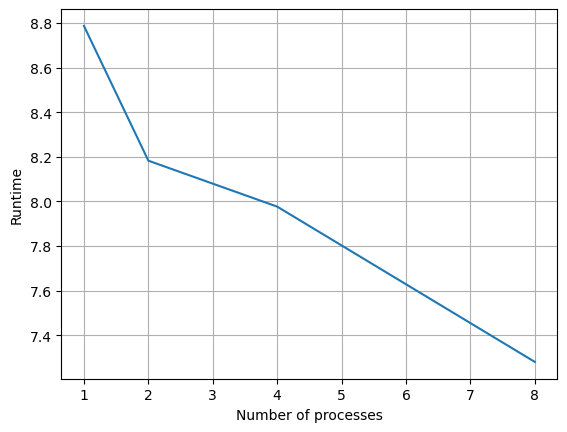

In [7]:
import matplotlib.pyplot as plt
print("Average runtimes")
for num_processes, runtime in zip(mpi_processes, runtimes):
    print(num_processes, runtime)
plt.plot(mpi_processes, runtimes)
plt.xlabel("Number of processes")
plt.ylabel("Runtime")
plt.grid()